In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from models.mobilenet import load_model, preprocess, decode_predictions
from methods.fgsm import create_adversarial_pattern

# Load model and preprocess image
model = load_model()
image_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg', 
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)

# Display images
def display_images(model, image, description):
    _, label, confidence = decode_predictions(model.predict(image))
    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence * 100))
    plt.show()

# Predict and display the original image
display_images(model, image, 'Original Image')

# Generate adversarial pattern
loss_object = tf.keras.losses.CategoricalCrossentropy()
prediction = model.predict(image)
label = tf.one_hot(tf.argmax(prediction[0]), prediction.shape[-1])
label = tf.reshape(label, (1, prediction.shape[-1]))
perturbations = create_adversarial_pattern(model, loss_object, image, label)

# Use a single epsilon value
epsilon = 0.01
adv_x = image + epsilon * perturbations
adv_x = tf.clip_by_value(adv_x, -1, 1)

# Predict and display the adversarial image
display_images(model, adv_x, 'Adversarial image with Epsilon = {:0.3f}'.format(epsilon))

Original Image - Min: -1.0, Max: 1.0


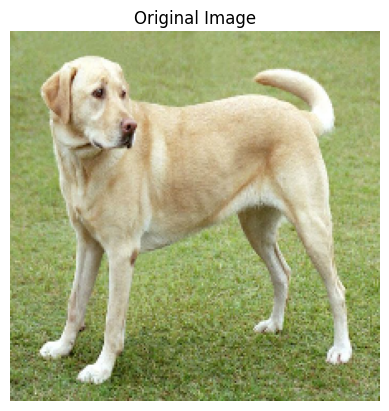

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
Adversarial Image at iteration 1 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 2 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 3 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 4 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 5 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 6 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 7 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 8 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 9 - Min: -1.0, Max: 1.0
Adversarial Image at iteration 10 - Min: -1.0, Max: 1.0
Final Adversarial Image - Min: -1.0, Max: 1.0


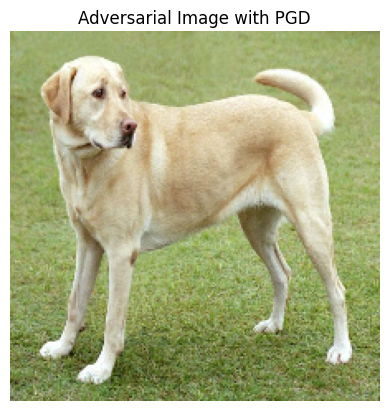

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050000027..0.050000027].


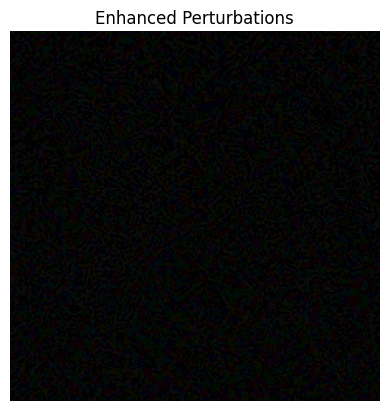

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt

def print_pixel_range(image, description):
    print(f"{description} - Min: {tf.reduce_min(image).numpy()}, Max: {tf.reduce_max(image).numpy()}")

def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

def decode_predictions(preds):
    decoded = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=1)[0][0]
    label = decoded[1]
    confidence = decoded[2]
    return label, confidence

def display_images(image, description):
    plt.imshow(image)  # Display without additional scaling
    plt.title(description)
    plt.axis('off')
    plt.show()

def load_model():
    model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
    model.trainable = False
    return model

def create_adversarial_pattern(model, loss_object, input_image, input_label, epsilon=0.005, num_iterations=10, alpha=0.001):
    adv_image = tf.identity(input_image)  # Make a copy of the input image

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(adv_image)
            loss = loss_object(input_label, prediction)
        
        gradient = tape.gradient(loss, adv_image)
        signed_grad = tf.sign(gradient)
        adv_image = adv_image + alpha * signed_grad
        adv_image = tf.clip_by_value(adv_image, input_image - epsilon, input_image + epsilon)
        adv_image = tf.clip_by_value(adv_image, -1.0, 1.0)  # Ensure correct clipping for normalized values
        
        # Print pixel range of the intermediate adversarial image
        print_pixel_range(adv_image, f"Adversarial Image at iteration {i+1}")

    return adv_image

def denormalize(image):
    return (image + 1.0) / 2.0

# Load and preprocess image
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 
                                     'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)

# Print pixel range of the original image
print_pixel_range(image, "Original Image")

# Load model
model = load_model()

# Display the original image
display_images(denormalize(image[0]), 'Original Image')

# Generate adversarial pattern using PGD
loss_object = tf.keras.losses.categorical_crossentropy
prediction = model.predict(image)
label = tf.one_hot(tf.argmax(prediction[0]), prediction.shape[-1])
label = tf.reshape(label, (1, prediction.shape[-1]))

# Generate adversarial image
adv_image = create_adversarial_pattern(model, loss_object, image, label)

# Print pixel range of the final adversarial image
print_pixel_range(adv_image, "Final Adversarial Image")

# Denormalize and display the adversarial image
display_images(denormalize(adv_image[0]), 'Adversarial Image with PGD')

# Visualize the perturbations with enhanced contrast
perturbations = adv_image - image
enhanced_perturbations = perturbations * 10  # Enhance contrast for better visibility
display_images(enhanced_perturbations[0], 'Enhanced Perturbations')

In [ ]:
prediction = model.predict(image)
print("Prediction shape:", prediction[0].shape)

In [ ]:
print(decode_predictions(model.predict(image)))